In [1]:
"""
Abraham Tishelman-Charny 
22 September 2021 

The purpose of this notebook is to compare flashgg and NanoAOD framework outputs of the 
same process. As a first example, a comparison of SM HH->WWgg->qqlnugg with 2017 
detector reconstruction. The purpose being to show a NanoAOD framework produces 
the same results as flashgg. 
"""

'\nAbraham Tishelman-Charny \n22 September 2021 \n\nThe purpose of this notebook is to compare flashgg and NanoAOD framework outputs of the \nsame process. As a first example, a comparison of SM HH->WWgg->qqlnugg with 2017 \ndetector reconstruction. The purpose being to show a NanoAOD framework produces \nthe same results as flashgg. \n'

In [15]:
import uproot 
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd 

In [19]:
X = pd.read_parquet("../HHWWgg_SL/")
bins = np.linspace(115, 135, 80)

In [23]:
len(X['mass'][categories == 0])

130644

In [21]:
categories = X['best_tag']%40

print("N events hgg-coffea:")

fig, ax = plt.subplots()
plt.hist(X['mass'][categories == 0], bins = bins)
# cats = range(0, 4)
# objs = ["Leptons", "Jets"]
# for cat in cats:
#     for obj in objs:
#         exec("cat_%s_n%s = X['n%s'][categories == %s]"%(cat, obj, obj, cat))
        
# for cat in cats:
#     for obj in objs:
#         quantity = "cat_%s_n%s"%(cat, obj)
#         exec("vals = %s"%(quantity))
#         fig, ax = plt.subplots()
#         plt.hist(vals, bins = np.linspace(0, 7, 8))
#         plt.yscale('log')
#         ymin, ymax = ax.get_ylim()
#         ax.set_ylim(0.1, ymax)
#         plt.title(quantity)
#         plt.show()
#         plt.close()        

TypeError: 'int' object is not callable

In [2]:
# MiniAOD: /GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/RunIIFall17MiniAODv2-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/MINIAODSIM
# NanoAOD: /GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/NANOAODSIM
flashgg_ntuple = uproot.open("GluGluToHHTo2G2Qlnu_node_cHHH1_2017.root")

In [8]:
flashgg_SL_tree = flashgg_ntuple["tagsDumper/trees"]["GluGluToHHTo2G2Qlnu_node_cHHH1_13TeV_HHWWggTag_0"]

In [10]:
flashgg_SL_mass = flashgg_SL_tree["CMS_hgg_mass"].array()

flashgg N entries: 76293


(array([  52.,   66.,   69.,   61.,   70.,   68.,   88.,   84.,  101.,
         115.,  121.,  153.,  151.,  173.,  189.,  231.,  237.,  287.,
         341.,  386.,  434.,  541.,  610.,  656.,  820.,  976., 1173.,
        1226., 1456., 1685., 2001., 2264., 2589., 3084., 3222., 3516.,
        3679., 3798., 4085., 3887., 3658., 3608., 3232., 3085., 2723.,
        2282., 1967., 1636., 1423., 1141.,  950.,  832.,  635.,  577.,
         452.,  368.,  333.,  247.,  258.,  195.,  153.,  134.,  103.,
          81.,   96.,   62.,   66.,   37.,   35.,   27.,   33.,   29.,
          24.,   19.,   15.,   11.,    7.,    5.,    6.]),
 array([115.        , 115.25316456, 115.50632911, 115.75949367,
        116.01265823, 116.26582278, 116.51898734, 116.7721519 ,
        117.02531646, 117.27848101, 117.53164557, 117.78481013,
        118.03797468, 118.29113924, 118.5443038 , 118.79746835,
        119.05063291, 119.30379747, 119.55696203, 119.81012658,
        120.06329114, 120.3164557 , 120.56962025, 120

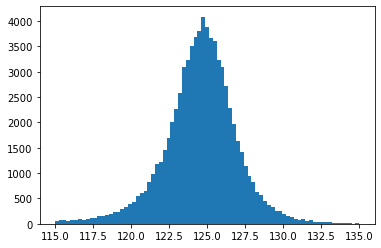

In [14]:
print("flashgg N entries:",len(flashgg_SL_mass))

fig, ax = plt.subplots()
bins = np.linspace(115, 135, 80)
plt.hist(flashgg_SL_mass, bins = bins)